(lgm1-notebook)=
# Curve di crescita latente 

In [103]:
source("_common.R")
suppressPackageStartupMessages({
    library("tidyverse")
    library("lavaan")
    library("semPlot")
    library("psych")
    library("DT")
    library("kableExtra")
    library("lme4")
    library("emmeans")
})
set.seed(42)

## Una applicazione concreta

Esaminiamo l'adattamento di un modello LGM ad un campione di dati reali. In questo tutorial, considereremo il cambiamento nel rendimento in matematica dei bambini durante la scuola elementare e media utilizzando il set di dati NLSY-CYA {cite:p}`grimm2016growth`. Iniziamo a leggere i dati.

In [104]:
#set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_wide_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_wide <- dat

# Give the variable names
names(nlsy_math_wide) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "age2", "age3", "age4", "age5", "age6", "age7", "age8",
  "men2", "men3", "men4", "men5", "men6", "men7", "men8",
  "spring2", "spring3", "spring4", "spring5", "spring6", "spring7", "spring8",
  "anti2", "anti3", "anti4", "anti5", "anti6", "anti7", "anti8"
)

# view the first few observations (and columns) in the data set
head(nlsy_math_wide[, 1:11], 10)

,id,female,lb_wght,anti_k1,math2,math3,math4,math5,math6,math7,math8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,NA,38,NA,55,NA,NA,NA
2,303,1,0,1,26,NA,NA,33,NA,NA,NA
3,2702,0,0,0,56,NA,58,NA,NA,NA,80
4,4303,1,0,0,NA,41,58,NA,NA,NA,NA
5,5002,0,0,4,NA,NA,46,NA,54,NA,66
6,5005,1,0,0,35,NA,50,NA,60,NA,59
7,5701,0,0,2,NA,62,61,NA,NA,NA,NA
8,6102,0,0,0,NA,NA,55,67,NA,81,NA
9,6801,1,0,0,NA,54,NA,62,NA,66,NA


Il nostro interesse specifico riguarda il cambiamento relativo alle misure ripetute di matematica, da `math2` a `math8`.

Selezioniamo le variabili di interesse.

In [105]:
nlsy_math_sub <- nlsy_math_wide |>
    dplyr::select("id", "math2", "math3", "math4", "math5", "math6", "math7", "math8")

Trasformiamo i dati in formato *long*.

In [106]:
nlsy_math_long <- reshape(
  data = nlsy_math_sub,
  timevar = c("grade"),
  idvar = "id",
  varying = c(
    "math2", "math3", "math4",
    "math5", "math6", "math7", "math8"
  ),
  direction = "long", sep = ""
)

Ordiniamo i dati in base alle variabili `id` e `grade`.

In [85]:
nlsy_math_long <- nlsy_math_long[order(nlsy_math_long$id, nlsy_math_long$grade), ]

Rimuoviamo gli NA dalla variabile `math` per potere generare il grafico con le traiettorie individuali di sviluppo

In [86]:
nlsy_math_long <- nlsy_math_long[which(is.na(nlsy_math_long$math) == FALSE), ]

Guardiamo prima i dati grezzi.

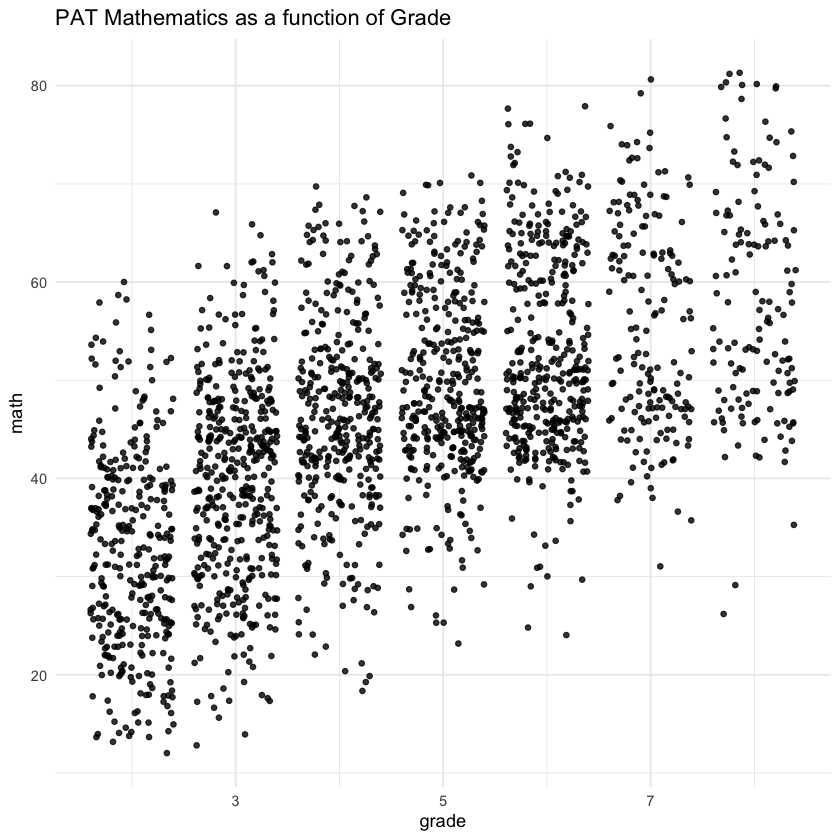

In [87]:
nlsy_math_long |>
  ggplot(aes(x = grade, y = math)) +
  geom_point(
    size = 1.2,
    alpha = .8,
    # to add some random noise for plotting purposes
    position = "jitter"
  ) +
  theme_minimal() +
  labs(title = "PAT Mathematics as a function of Grade")


Aggiungiamo al grafico le retta dei minimi quadrati calcolata su tutti i dati (ignorando il ragruppamento dei dati in funzine degli individui). 

`geom_smooth()` using formula = 'y ~ x'


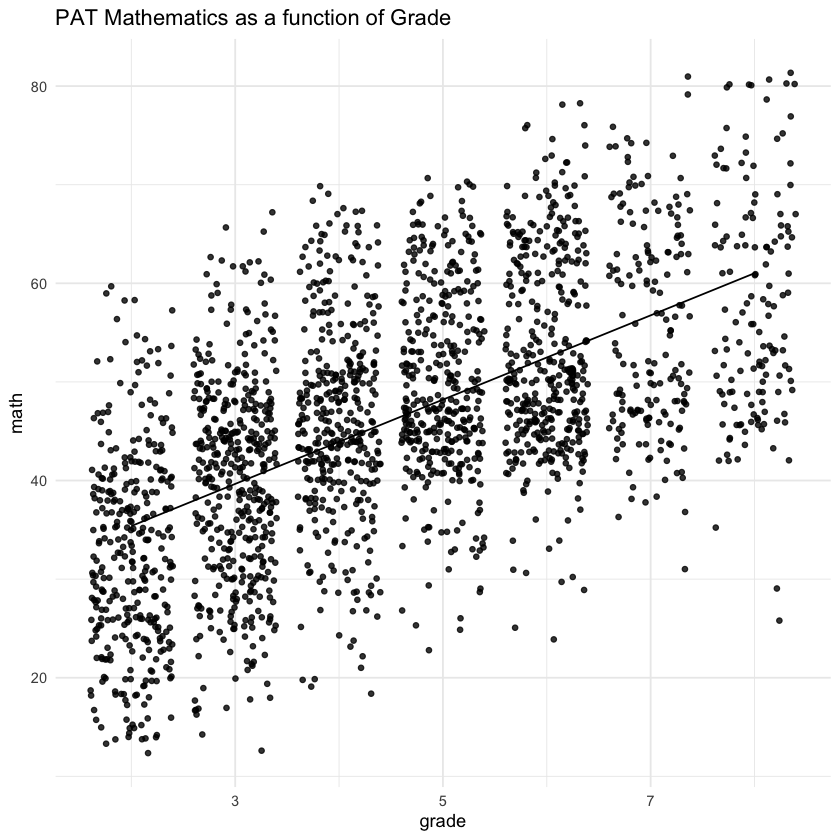

In [88]:
nlsy_math_long |>
    ggplot(aes(x = grade, y = math)) +
    geom_point(
        size = 1.2,
        alpha = .8,
        # to add some random noise for plotting purposes
        position = "jitter"
    ) +
    geom_smooth(
        method = lm,
        se = FALSE,
        col = "black",
        linewidth = .5,
        alpha = .8
    ) + # to add regression line
    theme_minimal() +
    labs(title = "PAT Mathematics as a function of Grade")


Esaminiamo ora le traiettorie intraindividuali di cambiamento.

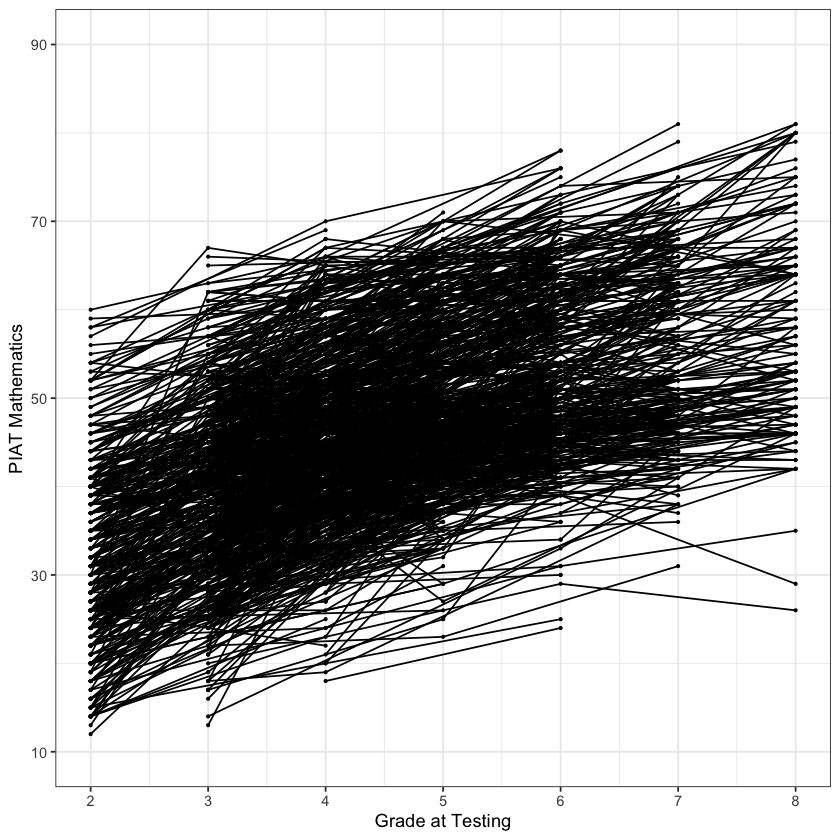

In [89]:
# intraindividual change trajetories
nlsy_math_long |>
  ggplot(
    aes(x = grade, y = math, group = id)
  ) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "PIAT Mathematics"
  )


## Modello di assenza di crescita

Come mostrato nel grafico precedente, sembra esserci una crescita sistematica nei punteggi di matematica nel tempo. Per iniziare l’analisi, adatteremo un modello senza crescita che agirà come un  modello “baseline” con cui confrontare i modelli successivi.

Questo modello ipotizza un livello costante dei punteggi di matematica degli individui nel tempo e si limita a stimare, per ciascun invididuo, il "valore vero" dei punteggi di matematica (senza errore di misura) indipendente dal tempo. Non prevedendo che i punteggi cambino in funzione del tempo, il modello descrive un caso di poco interesse e, quindi, solitamente  questo è un modello che vogliamo respingere. 

Questo modello include una variabile latente e un’intercetta che rappresenta il livello complessivo di prestazione invariante nel tempo.

Per impostare il modello senza crescita, utilizzeremo la seguente sintassi di lavaan.

In [108]:
ng_math_lavaan_model <- ' 
  # latent variable definitions
      #intercept
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

  # factor variances
      eta_1 ~~ eta_1

  # covariances among factors 
      #none (only 1 factor)

  # factor means 
      eta_1 ~ start(30)*1

  # manifest variances (made equivalent by naming theta)
      math2 ~~ theta*math2
      math3 ~~ theta*math3
      math4 ~~ theta*math4
      math5 ~~ theta*math5
      math6 ~~ theta*math6
      math7 ~~ theta*math7
      math8 ~~ theta*math8
  # manifest means (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1
' #end of model definition

Adattiamo il modello ai dati.

In [91]:
ng_math_lavaan_fit <- sem(ng_math_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”
Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”
Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo la soluzione.

In [92]:
summary(ng_math_lavaan_fit, fit.measures = TRUE) |>
    print()

lavaan 0.6.15 ended normally after 18 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         9
  Number of equality constraints                     6

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        60            

Model Test User Model:
                                                      
  Test statistic                              1759.002
  Degrees of freedom                                32
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               862.334
  Degrees of freedom                                21
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.000

Otteniamo il diagramma di percorso.

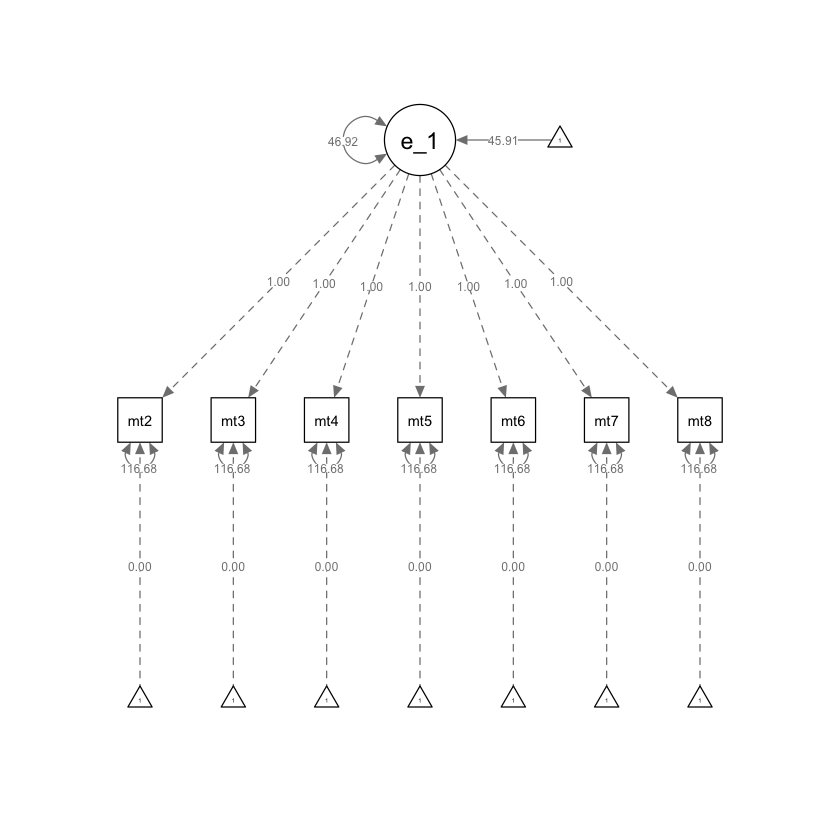

In [94]:
semPaths(ng_math_lavaan_fit, what = "path", whatLabels = "par")

Calcoliamo le traiettorie predette.

In [95]:
#obtaining predicted factor scores for individuals
nlsy_math_predicted <- as.data.frame(cbind(nlsy_math_wide$id,lavPredict(ng_math_lavaan_fit)))

#naming columns
names(nlsy_math_predicted) <- c("id", "eta_1")

#looking at data
head(nlsy_math_predicted) 

,id,eta_1
,<dbl>,<dbl>
1,201,46.17558
2,303,38.59816
3,2702,56.16725
4,4303,47.51278
5,5002,51.06429
6,5005,49.05038


Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


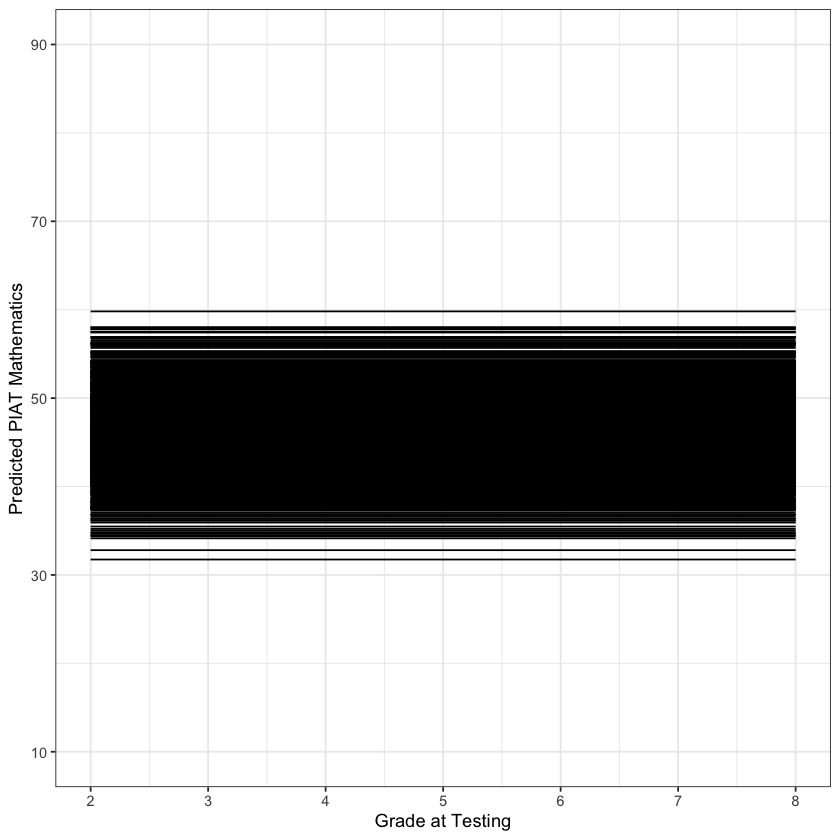

In [96]:
# calculating implied manifest scores
nlsy_math_predicted$math2 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math3 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math4 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math5 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math6 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math7 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math8 <- 1 * nlsy_math_predicted$eta_1

# reshaping wide to long
nlsy_math_predicted_long <- reshape(
  data = nlsy_math_predicted,
  timevar = c("grade"),
  idvar = "id",
  varying = c(
    "math2", "math3", "math4",
    "math5", "math6", "math7", "math8"
  ),
  direction = "long", sep = ""
)
# sorting for easy viewing
# order by id and time
nlsy_math_predicted_long <- nlsy_math_predicted_long[order(nlsy_math_predicted_long$id, nlsy_math_predicted_long$grade), ]

# intraindividual change trajetories
ggplot(
  data = nlsy_math_predicted_long, # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  # geom_point(size=.5) + #adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "Predicted PIAT Mathematics"
  )


Vediamo dal grafico che, come richiesto, il modello produce una traiettoria di crescita piatta per ciascun individuo.

## Modello di crescita lineare

Nella discussione dei modelli di crescita, dopo il modello di assenza di crescita, si esamina sempre il modello di crescita lineare a causa della sua semplicità. Inoltre, i modelli di crescita lineare sono spesso un punto di partenza quando si cerca di comprendere il cambiamento all’interno della persona.

Implementiamo dunque un modello di crescita latente lineare.

In [99]:
lg_math_lavaan_model <- '
  # latent variable definitions
      #intercept (note intercept is a reserved term)
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

      #linear slope 
      eta_2 =~ 0*math2
      eta_2 =~ 1*math3
      eta_2 =~ 2*math4
      eta_2 =~ 3*math5
      eta_2 =~ 4*math6
      eta_2 =~ 5*math7
      eta_2 =~ 6*math8

  # factor variances
      eta_1 ~~ eta_1
      eta_2 ~~ eta_2

  # covariances among factors 
      eta_1 ~~ eta_2

  # factor means 
      eta_1 ~ 1
      eta_2 ~ 1

  # manifest variances (made equivalent by naming theta)
      math2 ~~ theta*math2
      math3 ~~ theta*math3
      math4 ~~ theta*math4
      math5 ~~ theta*math5
      math6 ~~ theta*math6
      math7 ~~ theta*math7
      math8 ~~ theta*math8
  # manifest means (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1
' #end of model definition

Adattiamo il modello ai dati.

In [100]:
lg_math_lavaan_fit <- sem(lg_math_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”
Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”
Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo il risultato ottenuto.

In [78]:
summary(lg_math_lavaan_fit, fit.measures = TRUE) |>
    print()

lavaan 0.6.15 ended normally after 38 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        12
  Number of equality constraints                     6

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        60            

Model Test User Model:
                                                      
  Test statistic                               204.484
  Degrees of freedom                                29
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               862.334
  Degrees of freedom                                21
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.791

Generiamo un diagramma di percorso.

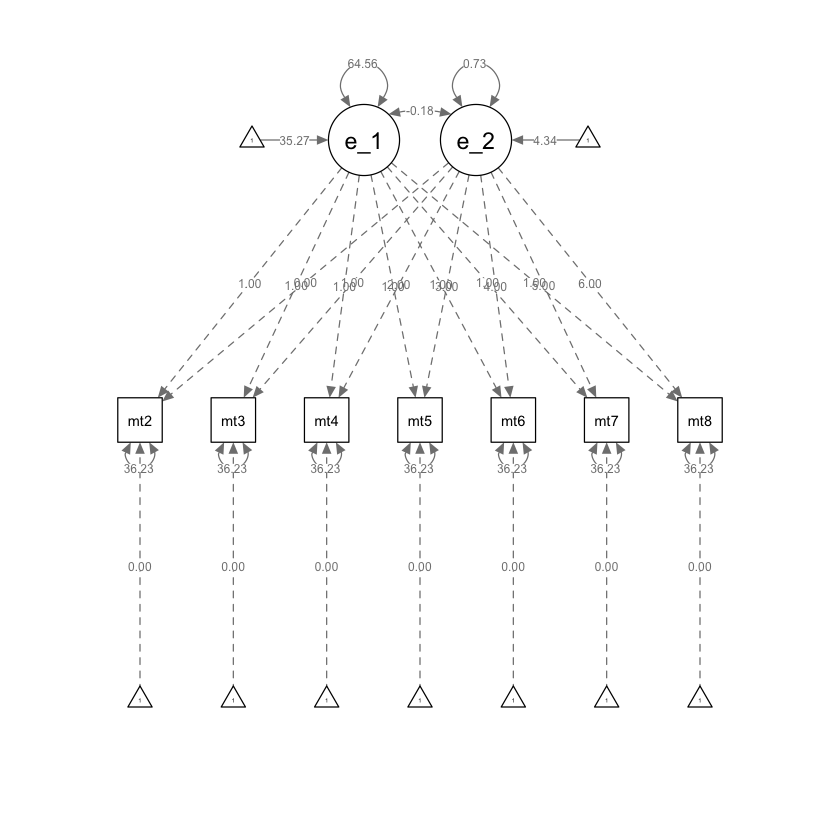

In [17]:
semPaths(lg_math_lavaan_fit,what = "path", whatLabels = "par")

Esaminiamo le traiettorie di crescita.

In [18]:
nlsy_math_predicted <- as.data.frame(
    cbind(nlsy_math_wide$id, lavPredict(lg_math_lavaan_fit))
)

#naming columns
names(nlsy_math_predicted) <- c("id", "eta_1", "eta_2")

head(nlsy_math_predicted)

,id,eta_1,eta_2
,<dbl>,<dbl>,<dbl>
1,201,36.94675,4.534084
2,303,26.03589,4.050780
3,2702,49.70187,4.594149
4,4303,41.04200,4.548064
5,5002,37.01240,4.496746
6,5005,37.68809,4.324198


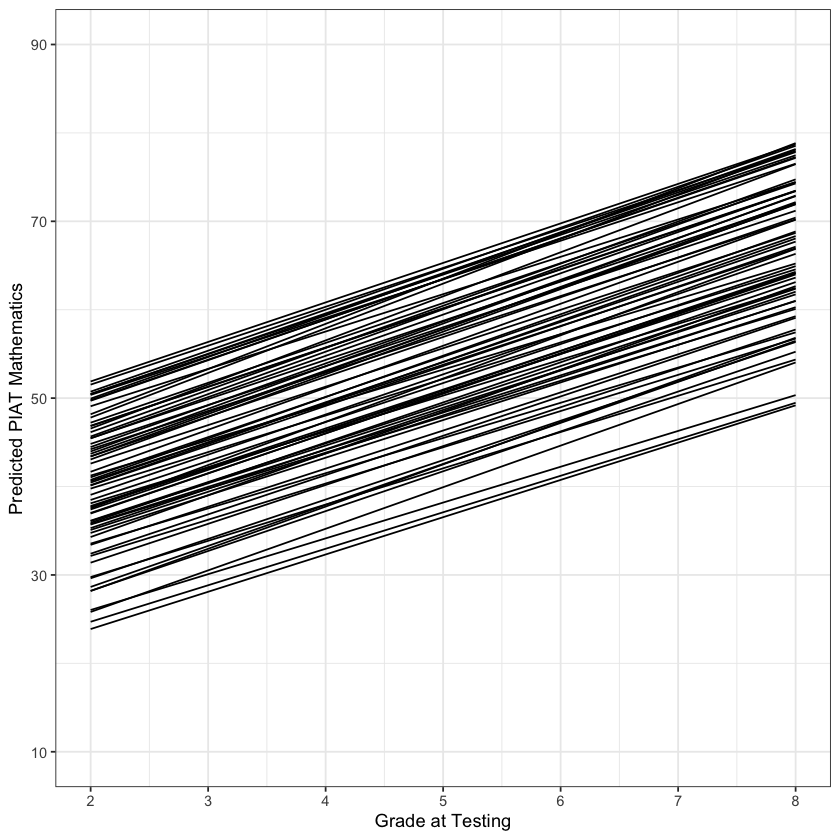

In [20]:
#calculating implied manifest scores
nlsy_math_predicted$math2 <- 1 * nlsy_math_predicted$eta_1 + 0 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math3 <- 1 * nlsy_math_predicted$eta_1 + 1 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math4 <- 1 * nlsy_math_predicted$eta_1 + 2 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math5 <- 1 * nlsy_math_predicted$eta_1 + 3 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math6 <- 1 * nlsy_math_predicted$eta_1 + 4 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math7 <- 1 * nlsy_math_predicted$eta_1 + 5 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math8 <- 1 * nlsy_math_predicted$eta_1 + 6 * nlsy_math_predicted$eta_2

# reshaping wide to long
nlsy_math_predicted_long <- reshape(
  data = nlsy_math_predicted,
  timevar = c("grade"),
  idvar = "id",
  varying = c(
    "math2", "math3", "math4",
    "math5", "math6", "math7", "math8"
  ),
  direction = "long", sep = ""
)
# sorting for easy viewing
# order by id and time
nlsy_math_predicted_long <-
  nlsy_math_predicted_long[order(nlsy_math_predicted_long$id, nlsy_math_predicted_long$grade), ]

# intraindividual change trajetories
ggplot(
  data = nlsy_math_predicted_long[which(nlsy_math_predicted_long$id < 80000), ], # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  # geom_point(size=.5) + #adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "Predicted PIAT Mathematics"
  )

Dal grafico si può notare che questo modello rappresenta la traiettoria di ogni bambino come una linea retta, con alcune differenze interindividuali nella velocità del cambiamento intraindividuale. 

Dal grafico vediamo come, ad un aumento di un anno nel grado scolastico, il punteggio "vero" di matematica aumenta circa di 5 punti. 

### Sintassi alternativa

È possibile semplificare la scrittura del modello usando la funzione `growth`. Rispetto ai default di `growth` è necessario specificare, per il modello discusso in precedenza, il fatto vogliamo che le varianze residue di `math` siano costanti nel tempo.

In [ ]:
m1 <-   '
  i =~ 1*math2 + 1*math3 + 1*math4 + 1*math5 + 1*math6 + 1*math7 + 1*math8  
  s =~ 0 * math2 + 1 * math3 + 2 * math4 + 3 * math5 + 4 * math6 + 5 * math7 + 6 * math8
  
  # manifest variances (made equivalent by naming theta)
  math2 ~~ theta*math2
  math3 ~~ theta*math3
  math4 ~~ theta*math4
  math5 ~~ theta*math5
  math6 ~~ theta*math6
  math7 ~~ theta*math7
  math8 ~~ theta*math8
'

Adattiamo il  modello.

In [ ]:
fit_m1 <- growth(
  m1,
  data = nlsy_math_wide, 
  estimator = "ML",
  missing = "fiml")

Otteniamo lo stesso risultato trovato con `sem`.

In [148]:
print(fitMeasures(fit_m1, c("chisq", "df", "pvalue", "cfi", "rmsea")))

  chisq      df  pvalue     cfi   rmsea 
204.484  29.000   0.000   0.791   0.081 


### Interpretazione dei parametri

Nell'output relativo ad `Intercepts`, il valore `eta_1`  uguale a 35.267 indica il valore predetto di matematica al tempo $t_0$. Il parametro `eta_2` specifica che, per ogni incremento di un'unità sulla metrica utilizzata del tempo, ci si aspetto che il valore predetto di matematica aumenti di 4.339 punti. Nell'output relativo ad `Variances`, il parametro `eta_1` uguale a 64.562 indica la varianza delle intercette tra gli studenti; il parametro `eta_2` uguale a 0.733 indica la varianza delle pendenze tra gli studenti. Prendendo la radice quadrata e assumendo la normalità, l'intervallo $35.267 \pm 1.96 \sqrt(64.562)$ fornisce una stima dell'intervallo al 95% dei valori plausibili delle medie dei punteggi di matematica tra gli studenti -- non l'intervallo di fiducia frequentista, in quanto l'intervallo è calcolato attorno alla stima del valore vero.  In maniera corrispondente, l'intervallo $4.339 \pm 1.96 \sqrt(0.733)$ fornisce una stima dell'intervallo al 95% dei valori plausibili delle pendenze dei punteggi di matematica tra gli studenti. 

La covarianza stimata di -0.181 (*SE* = 1.150) indica che non vi è covarianza tra intercette e pendenze. Se l’effetto fosse positivo, potremmo dire che c’è una relazione positiva tra l’intercetta e la pendenza: più alto è il valore iniziale di matematica, più forte è la crescita dei punteggi di matematica nel tempo. Una covarianza negativa tra intercetta e pendenza implicherebbe che più alto è il punteggio iniziale di matematica, più debole è l’aumento dei puneggi di matematica nel tempo.

## Confronto con il modello misto

Facciamo nuovamente l'analisi usando un modello misto. Nel caso di questo esempio, non possiamo ottenere gli stessi risulati a causa dei valori mancanti. Usando `lavaan`, per stimare i parametri del modello abbiamo usato la procedura di stima di massima verosimiglianza (ML) e abbiamo affrontato il problema dei dati mancanti usando la procedura `fiml`. Questo metodo non imputa alcun dato, ma piuttosto utilizza i dati disponibili di ogni caso per calcolare le stime di massima verosimiglianza dei parametri.  Nel caso dei modelli misti, invece, la strategia di stima di Full Information Maximum Likelihood (FIML) non è disponibile.  Pertanto procederemo semplicemente eliminando tutti i casi nei quali vi sono dei dati mancanti.  

In formato *long*, i dati sono i seguenti.

In [21]:
nlsy_math_long |>
    head()

,id,grade,math
,<int>,<dbl>,<int>
201.3,201,3,38
201.5,201,5,55
303.2,303,2,26
303.5,303,5,33
2702.2,2702,2,56
2702.4,2702,4,58


Sottraiamo 2 dalla variabile `grade` in modo tale che 0 corrisponda alla prima rilevazione temporale. In queste circostanze, l'intercetta corrisponderà al valore atteso del punteggio di matematica per la prima rilevazione temporale (`grade` uguale a 2).

In [60]:
nlsy_math_long$grade_c2 <- nlsy_math_long$grade - 2

Adattiamo il modello misto usando `lmer`. Si noti che il modello è ad intercetta casuale, ovvero assume la stessa pendenza per ciascun individuo (lo stesso tasso di crescita). Ciò corrisponde alla situazione illustrata dalla figura precedente che mostra le traiettorie di crescita.

L'argomento `REML = FALSE` indica che useremo la stima di massima verosimiglianza, anziché la procedura di default. L'argomento `na.action = na.exclude` rende esplicito il fatto che escluderemo le osservazioni con dati mancanti.

In [61]:
fit_lmer <- lmer(
    math ~ 1 + grade_c2 + (1 | id),
    data = nlsy_math_long,
    REML = FALSE,
    na.action = na.exclude
)

In [62]:
summary(fit_lmer) |>
    print()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: math ~ 1 + grade_c2 + (1 | id)
   Data: nlsy_math_long

     AIC      BIC   logLik deviance df.resid 
 15957.7  15980.5  -7974.8  15949.7     2217 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2082 -0.5265  0.0081  0.5456  2.5651 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 67.30    8.204   
 Residual             39.31    6.270   
Number of obs: 2221, groups:  id, 932

Fixed effects:
            Estimate Std. Error t value
(Intercept) 35.33081    0.36264   97.43
grade_c2     4.29352    0.08266   51.94

Correlation of Fixed Effects:
         (Intr)
grade_c2 -0.555


Dall'output vediamo che il punteggio di matematica in corrispondenza del secondo grado scolastico (codificato qui con 0) è uguale a 35.33 (0.36). Il tasso di crescita, ovvero l'aumento atteso dei punteggi di matematica per ciascun grado scolastico è uguale a 4.29 (0.08). 

Una rappresentazione grafica dei punteggi predetti dal modello misto può essere ottenuta nel modo seguente.

In [63]:
gr <- emmeans::ref_grid(fit_lmer, cov.keep= c('grade_c2'))
emm <- emmeans(gr, spec= c('grade_c2'), level= 0.95)

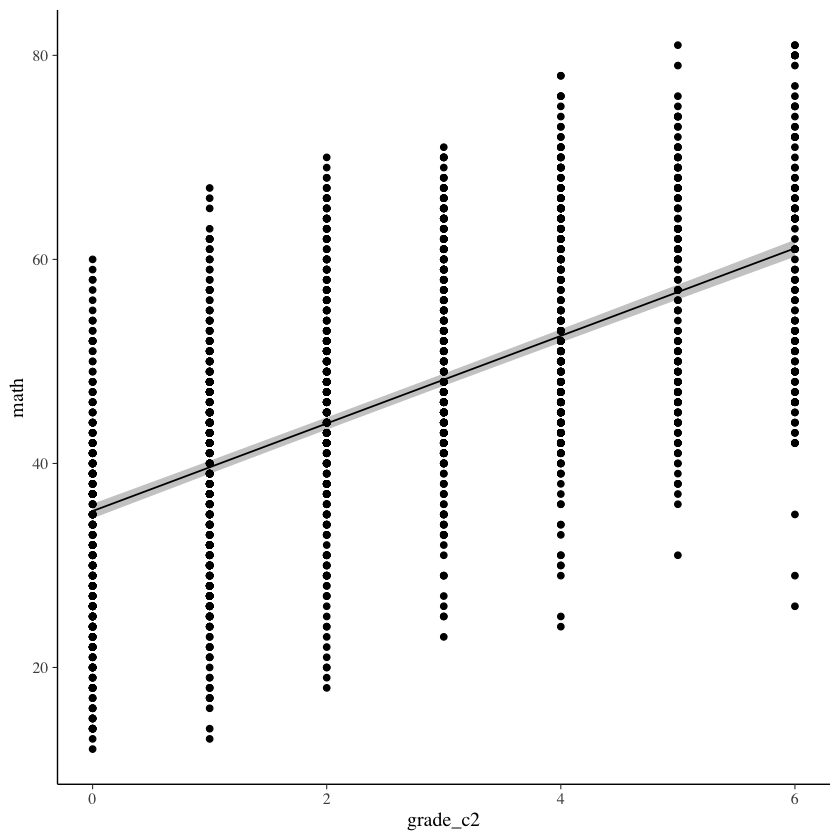

In [64]:
nlsy_math_long |>
    ggplot(aes(x= grade_c2, y= math)) +
        geom_ribbon(
            data= data.frame(emm), 
            aes(ymin= lower.CL, ymax= upper.CL, y= NULL), fill= 'grey80'
        ) +
        geom_line(data= data.frame(emm), aes(y= emmean)) +
        geom_point() 

Questi risultati, ottenuti escludendo tutte le osservazioni con dati mancanti, sono molto simili ai risultati ottenuti usando lavaan (si veda la figura con le traiettorie di crescita del modello LGM).

In [80]:
modindices(lg_math_lavaan_fit, sort = TRUE, maximum.number = 5)


,lhs,op,rhs,mi,epc,sepc.lv,sepc.all,sepc.nox
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,eta_2,=~,math2,101.79708,-1.2308189,-1.0534557,-0.10493110,-0.10493110
27,math2,~1,,101.22277,-5.3459823,-5.3459823,-0.53249490,-0.53249490
1,eta_1,=~,math2,93.95874,-0.1429373,-1.1485065,-0.11439878,-0.11439878
10,eta_2,=~,math4,57.13412,0.6947744,0.5946562,0.05859438,0.05859438
29,math4,~1,,56.12575,2.9968768,2.9968768,0.29529690,0.29529690


## Considerazioni conclusive

Questo tutorial ha illustrato come impostare e adattare modelli di crescita lineare nel framework di modellizzazione SEM utilizzando il pacchetto lavaan in R, nonché come calcolare e rappresentare graficamente le traiettorie di crescita previste dal modello.

I modelli di crescita lineare sono un punto di partenza per studiare il cambiamento individuale. Tuttavia, non sempre catturano bene il processo di cambiamento. Pertanto, è utile confrontare modelli aggiuntivi e considerare le differenze di gruppo. L’adattamento dei modelli di crescita nei framework di modellizzazione multilivello e delle equazioni strutturali ha vantaggi e limitazioni. Ad esempio, il framework delle equazioni strutturali fornisce indici di adattamento globale come RMSEA, CFI e TLI, mentre l’approccio dei modelli misti può usare solo AIC e BIC e le diagnostiche del modello come il grafico dei residui.”

Quando si adattano i modelli di crescita lineare, è importante considerare la metrica del tempo. Nel nostro esempio, abbiamo usato il grado scolastico come metrica temporale, ma altre metriche sono possibili. Ad esempio, l’età al momento del test potrebbe essere più rilevante perché cattura meglio la distanza tra le rilevazioni. Inoltre, ci possono essere limitazioni nell’utilizzo del grado scolastico, come nel caso di studenti che ripetono o saltano un anno.

L’intercetta può essere posizionata in qualsiasi punto temporale. Nel nostro esempio, l’abbiamo centrata sulla valutazione della seconda elementare perché era la prima misurazione disponibile. Tuttavia, è importante scegliere un punto di origine significativo per lo studio. Ad esempio, centrare l’intercetta alla fine dell’ottava elementare potrebbe essere importante per valutare la preparazione per la scuola superiore.


